# Projeto Final de Text Mining: Análise de Sentimentos nas Reviews da Plataforma IMDB (2024/2025)

Unidade Curricular: Text Mining

Docente: Ana Martins

Lourenço Costa, 120048

Marianna Oliveira, 120054

In [497]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier

In [498]:
df = pd.read_csv('IMDB Dataset.csv')

In [500]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Análise Exploratória

<BarContainer object of 2 artists>

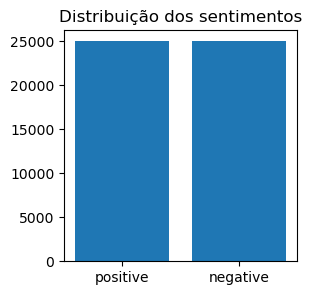

In [423]:
# Distribuição de sentimentos
plt.figure(figsize=(3, 3))
plt.title('Distribuição dos sentimentos')
valores = [df['sentiment'].value_counts().iloc[0],df['sentiment'].value_counts().iloc[1]]
cat = [df['sentiment'].value_counts().index[0],df['sentiment'].value_counts().index[1]]
plt.bar(cat,valores)

In [440]:
# Média do comprimenta das avaliações
print('A média de palavras por review é de',int(len(str(df['review'].tolist()).split(' '))/len(df)),'palavras')

A média de palavras por review é de 231 palavras


In [501]:
# Pre-processamento das reviews
stop_words = stopwords.words('english')
stop_words = set(stopwords.words('english'))

# Stop words adicionais tendo em conta o contexto do projeto
stop_words = stop_words.union([
    'movie', 'film', 'story', 'like', 'time', 'good', 'great',
    'really', 'bad', 'best', 'make', 'dont', 'know', 'play',
    'work', 'actor', 'scene', 'character', 'life', 'way', 'people'
])

lemmatizer = WordNetLemmatizer()

def preprocessamento(texto):
    texto = texto.lower()
    texto = texto.replace('<br /><br />','')
    texto = re.sub(r'[^a-z\s]', '', texto)
    tokens = word_tokenize(texto)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [502]:
df['review processada'] = df['review'].apply(preprocessamento)

In [503]:
df.head()

,review,sentiment,review processada
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful spend hot summer weekend sit...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love money visually stunning wa...


## Machine Learning

In [504]:
X = df['review processada']  
y = df['sentiment']  

y = y.map({'positive': 1, 'negative': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [508]:
log_reg_model = LogisticRegression(max_iter=700)
log_reg_model.fit(X_train_tfidf, y_train)

y_pred = log_reg_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.8871

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [512]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred = nb_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.8518

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      5000
           1       0.85      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [514]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)  # 100 trees in the forest
rf_model.fit(X_train_tfidf, y_train)

y_pred = rf_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      5000
           1       0.85      0.81      0.83      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## Modelo de Tópicos

In [ ]:
# Utilizar uma matriz documento-termo
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['review processada'])

# LDA para ver os tópicos latentes
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_model.fit(X)

In [450]:
topicos = pd.DataFrame(columns = ['palavras'])

for topic_idx, topic in enumerate(lda_model.components_):
    top_palavras = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:][::-1]]
    topicos.at[topic_idx,'palavras'] = " ".join(top_palavras)


In [462]:
for i in range(len(topicos)):
    print('Tópico',i+1)
    print(topicos['palavras'][i],'\n')

Tópico 1
war film world character american series year human director documentary 

Tópico 2
plot acting character actor script action performance cast better movie 

Tópico 3
funny comedy watch movie think seen love laugh watching episode 

Tópico 4
guy acting girl plot thing worst look watch minute woman 

Tópico 5
love woman man young family performance father mother wife child 

Tópico 6
horror effect thing movie look monster film zombie gore little 

Tópico 7
action fight film jack king man cartoon western little hero 

Tópico 8
think book say thing im read didnt seen watch movie 

Tópico 9
music song musical film performance role rock dance michael star 

Tópico 10
version original role cast james production john novel look star 



In [468]:
# Encontrar os indices das reviews que encaixam em cada tópico latente
doc_topic_matrix = lda_model.transform(X)

for i in range(len(topicos)):
    reviews_relacionadas = np.where(doc_topic_matrix[:, i] > 0.5)[0]
    indices_relacionados = reviews_relacionadas[np.argsort(-doc_topic_matrix[reviews_relacionadas, i])]
    topicos.at[i, 'review indices'] = str(indices_relacionados.tolist()).replace('[','').replace(']','')

In [469]:
topicos

,palavras,review indices
0,war film world character american series year ...,"9032, 6500, 39875, 4113, 29660, 42858, 28384, ..."
1,plot acting character actor script action perf...,"44829, 39731, 35434, 14586, 443, 38850, 24840,..."
2,funny comedy watch movie think seen love laugh...,"5796, 37706, 22546, 32890, 34043, 39896, 36589..."
3,guy acting girl plot thing worst look watch mi...,"14597, 24060, 30496, 34284, 13400, 19019, 1330..."
4,love woman man young family performance father...,"10450, 35675, 25967, 19484, 8165, 43482, 25926..."
5,horror effect thing movie look monster film zo...,"36526, 27515, 42032, 36175, 4432, 22769, 20134..."
6,action fight film jack king man cartoon wester...,"27426, 20379, 36765, 35479, 3877, 15672, 8526,..."
7,think book say thing im read didnt seen watch ...,"48674, 25806, 315, 43292, 17152, 43515, 19871,..."
8,music song musical film performance role rock ...,"48899, 13459, 39228, 11909, 8770, 19461, 27407..."
9,version original role cast james production jo...,"36168, 14442, 3217, 21236, 11578, 11993, 2795,..."


In [470]:
temas = ['Guerra e documentários','Criticas sobre personagens e plot','Comédia','Romance (baixa qualidade)',
         'Familia e Amor','Terror e Gore','Filmes de ação e cartoons',
         'Criticas à adaptação','Musicais','Remakes']

topicos['temas'] = temas

## Análise de dados

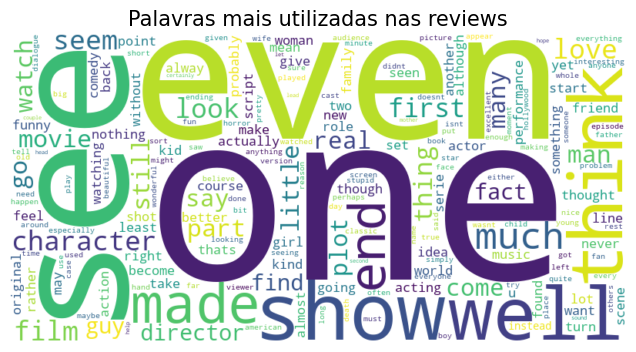

In [479]:
text = " ".join(df['review processada'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(9, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title("Palavras mais utilizadas nas reviews", fontsize=15)
plt.show()

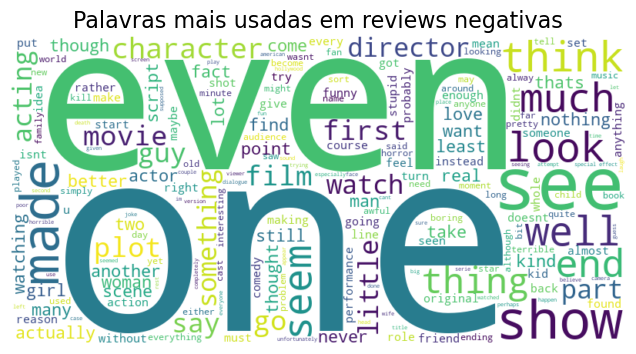

In [480]:
text = " ".join(df[df['sentiment'] == 'negative']['review processada'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(9, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title("Palavras mais usadas em reviews negativas", fontsize=16)
plt.show()


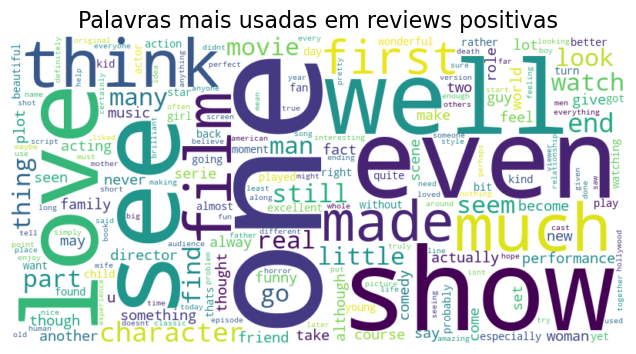

In [482]:
text = " ".join(df[df['sentiment'] == 'positive']['review processada'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(9, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title("Palavras mais usadas em reviews positivas", fontsize=16)
plt.show()

In [483]:
palavras_pos = [tup[0] for tup in pd.DataFrame(" ".join(df[df['sentiment'] == 'positive']['review processada'].tolist()).split(' ')).value_counts().head(100).index]
palavras_neg = [tup[0] for tup in pd.DataFrame(" ".join(df[df['sentiment'] == 'negative']['review processada'].tolist()).split(' ')).value_counts().head(100).index]

In [484]:
palavras_neg = set(palavras_neg)
palavras_pos = set(palavras_pos)

unicas_pos = palavras_neg - palavras_pos
unicas_neg = palavras_pos - palavras_neg

In [485]:
print("\nPalavras únicas no top 100 palavras mais usadas em comentários negativos: ", str(unicas_neg).replace('{','').replace('}',''),'\n')
print("Palavras únicas no top 100 palavras mais usadas em comentários positivos: ",str(unicas_pos).replace('{','').replace('}',''),'\n')


Palavras únicas no top 100 palavras mais usadas em comentários negativos:  'set', 'family', 'quite', 'bit', 'time', 'excellent', 'long', 'may', 'role', 'without', 'comedy', 'always', 'day', 'series', 'star', 'young', 'music', 'world', 'must', 'performance', 'saw', 'fun', 'right', 'fan', 'friend' 

Palavras únicas no top 100 palavras mais usadas em comentários positivos:  'thats', 'there', 'ive', 'anything', 'reason', 'script', 'horror', 'shot', 'least', 'enough', 'might', 'seems', 'pretty', 'minute', 'cant', 'effect', 'original', 'line', 'worst', 'isnt', 'try', 'whole', 'interesting', 'nothing', 'far' 



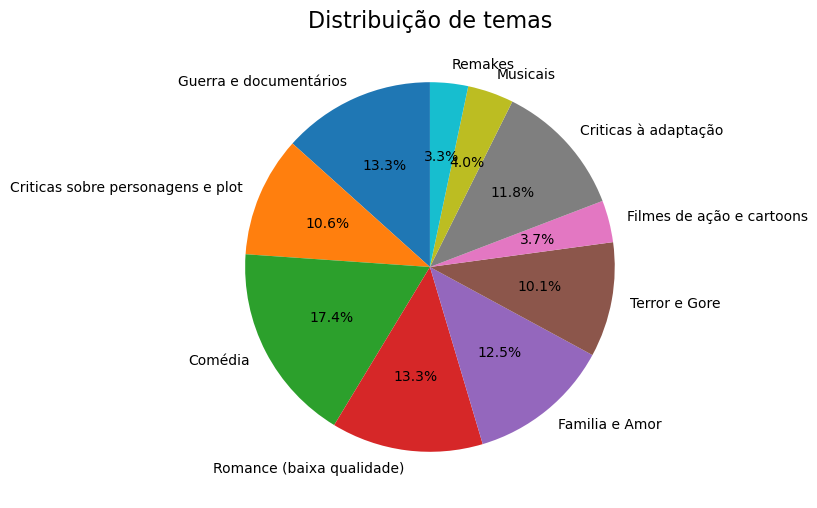

In [283]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.pie([len(topicos['review indices'][i].split(', ')) for i in range(len(topicos))], labels=[topicos['temas'][i] for i in range(len(topicos))], autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de temas', fontsize=16)

plt.show()

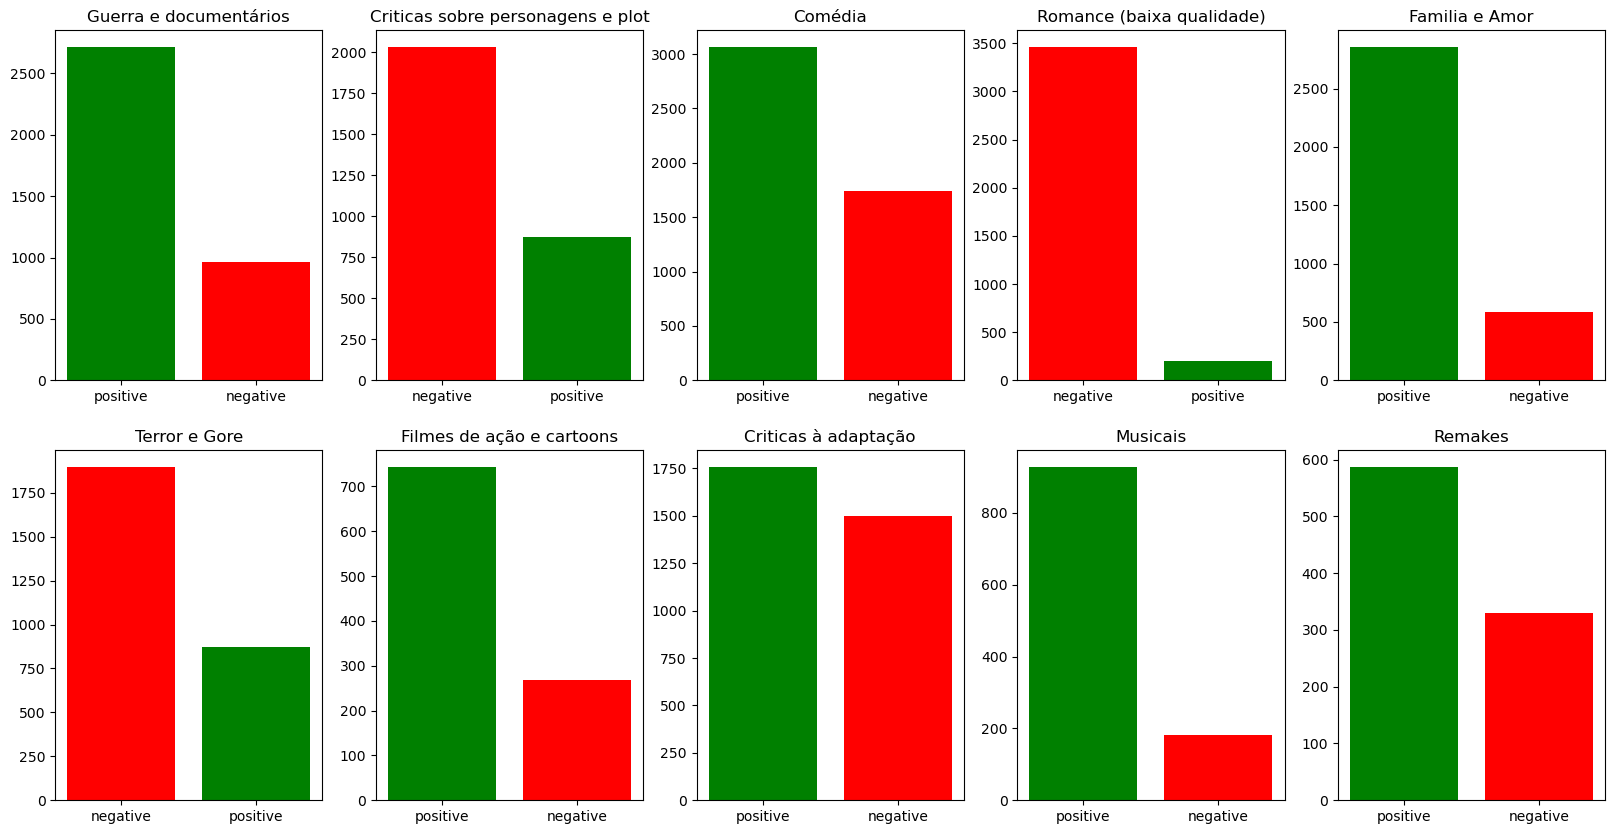

In [269]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axes = axes.flatten()

category_colors = { 'positive': 'green', 'negative': 'red'}

for i in range(10):
    axes[i].set_title(topicos['temas'][i])
    counts = df.iloc[topicos['review indices'][i].split(', ')]['sentiment'].value_counts()
    valores = [counts.iloc[0],counts.iloc[1]]
    cat = [counts.index[0],counts.index[1]]
    bar_colors = [category_colors[c] for c in cat]
    axes[i].bar(cat,valores,color=bar_colors)


In [ ]:
#Pie plot com positivos e negativos

In [395]:
valores_neg = []
valores_pos = []

for i in topicos.index:
    contador_pos = 0
    contador_neg = 0
    l = topicos['review indices'][i].split(', ')
    for idx in l:
        indice = int(idx)
        contador_total += 1
        if df.iloc[indice]['sentiment'] == 'positive':
            contador_pos += 1
        else:
            contador_neg += 1
    valores_neg.append(contador_neg)
    valores_pos.append(contador_pos)       

([<matplotlib.patches.Wedge at 0x19a24299a30>,
 [Text(0.9173611453086172, 0.606999612090537, 'Guerra e documentários'),
  Text(0.2329542435432245, 1.0750499153133328, 'Criticas sobre personagens e plot'),
  Text(-0.6521245654960862, 0.8858518787452793, 'Comédia'),
  Text(-1.0699252430026491, 0.25546031861273993, 'Romance (baixa qualidade)'),
  Text(-1.0031851264376281, -0.4512422875732285, 'Familia e Amor'),
  Text(-0.3725739248368472, -1.0349824493834026, 'Terror e Gore'),
  Text(0.0022489722399759303, -1.0999977009629902, 'Filmes de ação e cartoons'),
  Text(0.5658460524422867, -0.9433017782955152, 'Criticas à adaptação'),
  Text(0.9893424293854854, -0.480834230704955, 'Musicais'),
  Text(1.091233339092847, -0.13859942154379862, 'Remakes')],
 [Text(0.500378806531973, 0.3310906975039292, '18.6%'),
  Text(0.12706595102357698, 0.5863908628981815, '6.0%'),
  Text(-0.35570430845241063, 0.48319193386106135, '21.0%'),
  Text(-0.5835955870923539, 0.13934199197058542, '1.3%'),
  Text(-0.54719

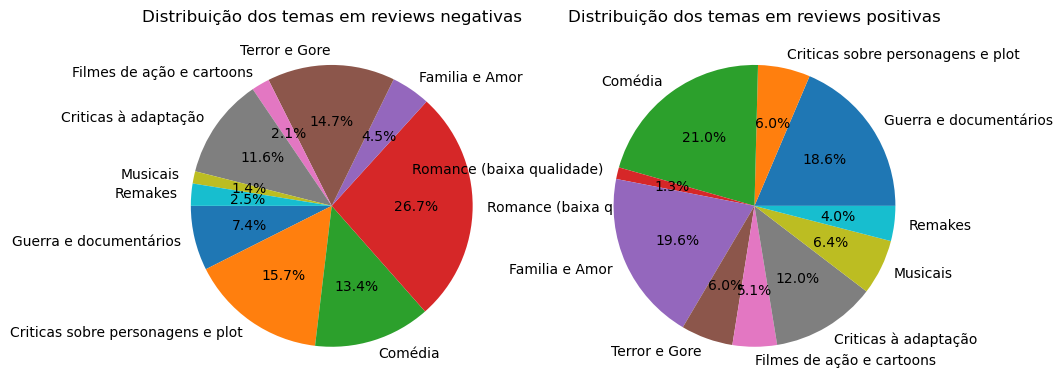

In [416]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes = axes.flatten()

axes[0].set_title('Distribuição dos temas em reviews negativas')
axes[0].pie(valores_neg, labels=[tema for tema in topicos['temas']],autopct='%1.1f%%',startangle=180)
axes[1].set_title('Distribuição dos temas em reviews positivas')
axes[1].pie(valores_pos, labels=[tema for tema in topicos['temas']],autopct='%1.1f%%')
